## This notebooks uses Partition A Surface Data with the OLS model to make snowfall predictions

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2008-2017 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


**Define dataframe which contains these features with concurrent snowfall events**

In [2]:
data = [pd.read_csv('test_train_df.dat', parse_dates = True, index_col = 'Date_Time')]
test_train_df = pd.concat(data)
print(len(test_train_df))


255


**This matches calculations made in the snowfall statistics analysis**

In [3]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
train_yrs_tt=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2013')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt = (test_train_df.index >= '01-01-2013') & (test_train_df.index < '01-01-2015')

print(len(test_train_df))

255


## Perform forward step feature selection using the OLS model

**Define surface+upper air features which have high data capture (as found in snowfall stats analysis)**

In [4]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', \
'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', \
'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp']+ \
['KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', \
             'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', \
             'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
             'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', \
             'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', 'KGJT_d700_400_height_m', \
             'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
             'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', \
             'KGJT_d700_200_speed_kts', 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', \
             'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', \
             'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', 'KGJT_d400_250_height_m', \
             'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
             'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', \
             'KGJT_d300_200_speed_kts', 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']



**Now use a forward stepwise methodology using the surface features and the OLS model.  Feature combinations which result in higher adjusted R squared values will be kept to train the model**

In [5]:

#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols


from collections import OrderedDict


variables_org = variables


print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    
    #print(max_var)

    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))

#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
#print(dictionary)

******


**Plot the adjusted R square calculated for each iteration**

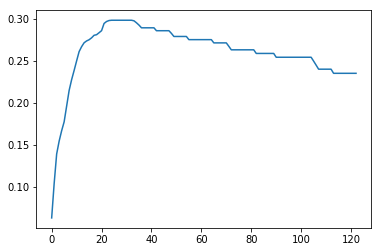

In [6]:
plt.plot(adjRs)

**Plot the adjusted F statistic calculated for each iteration**

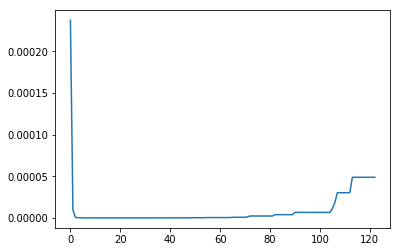

In [7]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [8]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        #print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()

#print(dictionary)

**Find max adj R and obtain OLS summary**

In [9]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
#print(maximum)

Print maximum:


**Thus the feature set with best capability looks to be these four features.  Let's look at the statsmdel regression results when just these features are used:**

In [10]:
maximum_all_str = max(dictionary, key=dictionary.get) 
#print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , test_train_df[train_yrs_tt]).fit() 
print(maxOLS_all.summary())


                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.389
Model:                                               OLS   Adj. R-squared:                  0.299
Method:                                    Least Squares   F-statistic:                     4.305
Date:                                   Sat, 18 May 2019   Prob (F-statistic):           4.77e-09
Time:                                           22:31:57   Log-Likelihood:                -361.56
No. Observations:                                    195   AIC:                             775.1
Df Residuals:                                        169   BIC:                             860.2
Df Model:                                             25                                         
Covariance Type:                               nonrobust                                         
                    

**We do note that some of the individual feature p values are still a little hight. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results using adjusted R squared as a metric**

In [14]:
rsq_adj = maxOLS_all.rsquared_adj
thresh = 0

goodp_str = maximum_all_str
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
#print(maximum_all_str)

print(maxOLS_all.pvalues[1])
for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  #print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  #print(highp_var)
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace(var+"+ ", "")  # if need to replace first feature in string
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
    
#    print(var)
#    print(testgoodp_str)
 

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str, test_train_df[train_yrs_tt]).fit()
  #print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      #print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01
      #print(thresh, goodp_str)

    
print("\n best p value threshold for feature elimination is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str, test_train_df[train_yrs_tt]).fit() 
print(maxOLS_goodp.summary())

0.4596538688721248

 best p value threshold for feature elimination is:0.3
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.386
Model:                                               OLS   Adj. R-squared:                  0.303
Method:                                    Least Squares   F-statistic:                     4.675
Date:                                   Sat, 18 May 2019   Prob (F-statistic):           1.38e-09
Time:                                           22:57:42   Log-Likelihood:                -362.04
No. Observations:                                    195   AIC:                             772.1
Df Residuals:                                        171   BIC:                             850.6
Df Model:                                             23                                         
Covariance Type:                           

**Doesn't like any improvement can be made**

## Make snowfall predictions

In [12]:



actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']

predict_snf = maxOLS_goodp.predict(test_train_df[test_yrs_tt])
print(len(actual_snf))
rows = zip(actual_snf, predict_snf)


60


**Write both actual and predicted snowfall values to csv file for future analysis

In [13]:
import csv
with open(r'C:\Users\RAPP\Documents\Capstone\Analysis Notebooks\model_predictions\B0-UASFC_OLS.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)